<a href="https://colab.research.google.com/github/SyKr0w/svm-cross-validation-diabetes/blob/main/SVM_Kfold10_X_Kfold5x2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM no Dataset Diabetes Pima

**Objetivo:** explorar SVM Linear e RBF, testar GridSearchCV (kernel, C e gamma) e comparar resultados usando KFold10 e RepeatedKFold 5x2.

# Conteúdo por célula
1. Execução padrão com SVM Linear (kernel='linear'), com split treino/teste
estratificado, métricas e matriz de confusão.
2. Kernel não linear (RBF) nas mesmas condições, para comparação.
3. GridSearchCV (apenas kernel): escolha entre linear, rbf.
4. Variação manual de C e gamma (quando aplicável).
5. GridSearchCV completo (kernel + C + gamma).

# Imports, utilidades e semente aleatória

In [1]:
# Import da tabela Pima Indians Diabetes Database
import requests

file_id = "1o2nNYlzckGamQaDxjvug_0G_mxlfo5cP"

url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Baixar e salvar na pasta
response = requests.get(url)
with open("/content/diabetes.csv", "wb") as f:
    f.write(response.content)


In [2]:
# Importação de bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap

# Estado fixo para reprodutibilidade
RANDOM_STATE = 42

# K-Fold estratificado (10 divisões) -> preserva proporção de classes
cv_k10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# RepeatedKFold (5 folds repetidos 2 vezes) -> mais robusto, reduz viés
cv_r5x2 = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

# Funções auxiliares
def plot_confusion_matrix(model, X_test, y_test, class_names, title):

    # Gera uma matriz de confusão
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, display_labels=class_names
    )
    plt.title(title)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

def scatter_pca_2d(X, y, title):

    # Aplica PCA para reduzir os dados a 2 dimensões
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(X)
    plt.figure()
    cmap = ListedColormap(['orange', 'purple']) # Orange for 0 (Non-Diabetic), Purple for 1 (Diabetic)
    scatter = plt.scatter(X2[:, 0], X2[:, 1], c=y, cmap=cmap)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


def scatter_pca_3d(X, y, title):

    # Aplica PCA para reduzir os dados a 3 dimensões
    pca = PCA(n_components=3, random_state=RANDOM_STATE)
    X3 = pca.fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cmap = ListedColormap(['orange', 'purple']) # Orange for 0 (Non-Diabetic), Purple for 1 (Diabetic)
    scatter = ax.scatter(X3[:, 0], X3[:, 1], X3[:, 2], c=y, cmap=cmap)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.title(title)
    plt.show()


---

## **1) Kfold10**

1.1 Carregamento, divisão e visualização PCA (opcional)


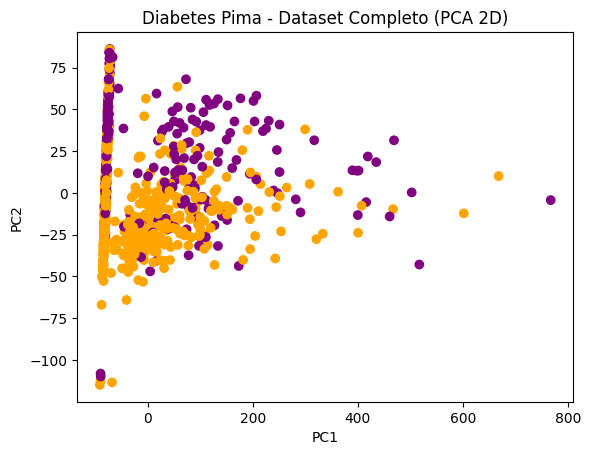

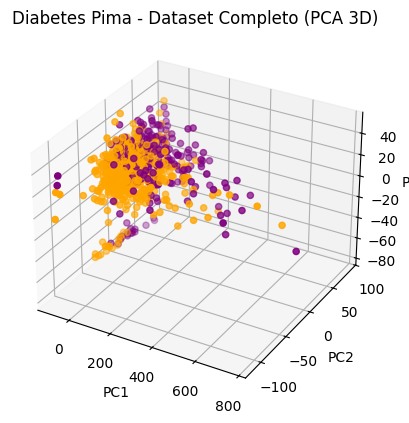

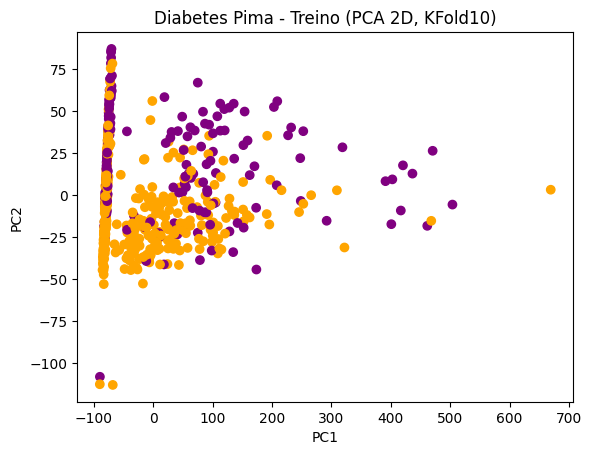

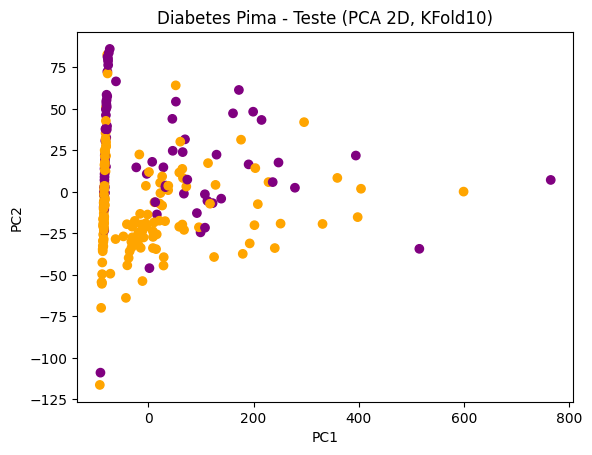

In [3]:
df = pd.read_csv("diabetes.csv")                #
X_d = df.drop("Outcome", axis=1).values         #  Carregamento do dataset com foco em binario: diabético (1) e não diabético (0)
y_d = df["Outcome"].values                      #
class_names_d = ["Não Diabético", "Diabético"]

# Visualização PCA (2D) do dataset completo
scatter_pca_2d(X_d, y_d, "Diabetes Pima - Dataset Completo (PCA 2D)")

# Visualização PCA (3D) do dataset completo
scatter_pca_3d(X_d, y_d, "Diabetes Pima - Dataset Completo (PCA 3D)")

# Divisão treino/teste (KFold10)
Xtr_d_k10, Xte_d_k10, ytr_d_k10, yte_d_k10 = train_test_split(
    X_d, y_d, test_size=0.3, stratify=y_d, random_state=RANDOM_STATE
)

# Visualização PCA (2D)
scatter_pca_2d(Xtr_d_k10, ytr_d_k10, "Diabetes Pima - Treino (PCA 2D, KFold10)")
scatter_pca_2d(Xte_d_k10, yte_d_k10, "Diabetes Pima - Teste (PCA 2D, KFold10)")

1.2 SVM Linear (baseline)

Relatório — SVM Linear (Diabetes Pima, KFold10)

               precision    recall  f1-score   support

Não Diabético       0.76      0.85      0.80       150
    Diabético       0.65      0.49      0.56        81

     accuracy                           0.73       231
    macro avg       0.70      0.67      0.68       231
 weighted avg       0.72      0.73      0.72       231

Acurácia: 0.7272727272727273


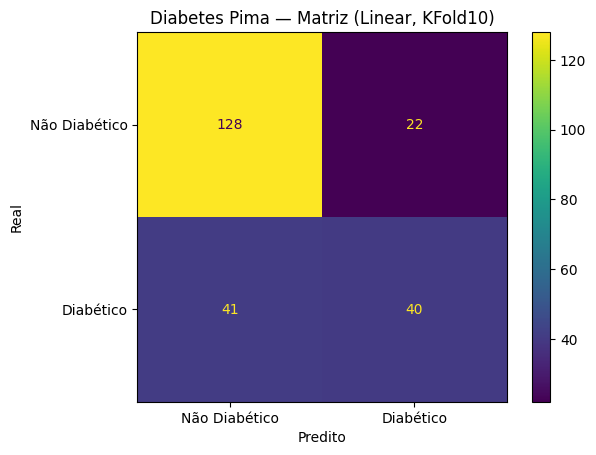

In [4]:
# Modelo SVM (Kernel Linear, KFold10)
pipe_linear_d_k10 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", random_state=RANDOM_STATE))
])

pipe_linear_d_k10.fit(Xtr_d_k10, ytr_d_k10)
ypred_d_k10 = pipe_linear_d_k10.predict(Xte_d_k10)

print("Relatório — SVM Linear (Diabetes Pima, KFold10)\n")
print(classification_report(yte_d_k10, ypred_d_k10, target_names=class_names_d))
print("Acurácia:", accuracy_score(yte_d_k10, ypred_d_k10))

plot_confusion_matrix(pipe_linear_d_k10, Xte_d_k10, yte_d_k10, class_names_d, "Diabetes Pima — Matriz (Linear, KFold10)")


1.3 Kernel não linear (RBF)

Relatório — SVM RBF (Diabetes Pima, KFold10)

               precision    recall  f1-score   support

Não Diabético       0.78      0.87      0.82       150
    Diabético       0.69      0.54      0.61        81

     accuracy                           0.75       231
    macro avg       0.73      0.70      0.71       231
 weighted avg       0.75      0.75      0.75       231

Acurácia: 0.7532467532467533


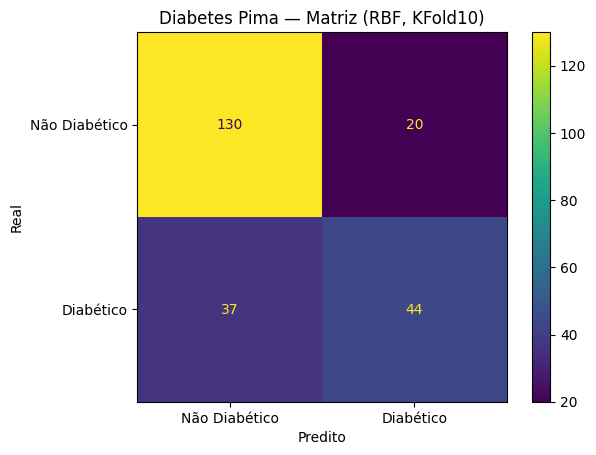

In [5]:
# Modelo SVM (Kernel RBF, KFold10)
pipe_rbf_d_k10 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", random_state=RANDOM_STATE))
])

pipe_rbf_d_k10.fit(Xtr_d_k10, ytr_d_k10)
ypred_d_k10_rbf = pipe_rbf_d_k10.predict(Xte_d_k10)

print("Relatório — SVM RBF (Diabetes Pima, KFold10)\n")
print(classification_report(yte_d_k10, ypred_d_k10_rbf, target_names=class_names_d))
print("Acurácia:", accuracy_score(yte_d_k10, ypred_d_k10_rbf))

plot_confusion_matrix(pipe_rbf_d_k10, Xte_d_k10, yte_d_k10, class_names_d, "Diabetes Pima — Matriz (RBF, KFold10)")


1.4 GridSearchCV (apenas kernel)

KFold10 — Melhor kernel: rbf
KFold10 — Melhor score de validação: 0.7767994409503843
KFold10 — Acurácia teste: 0.7532467532467533


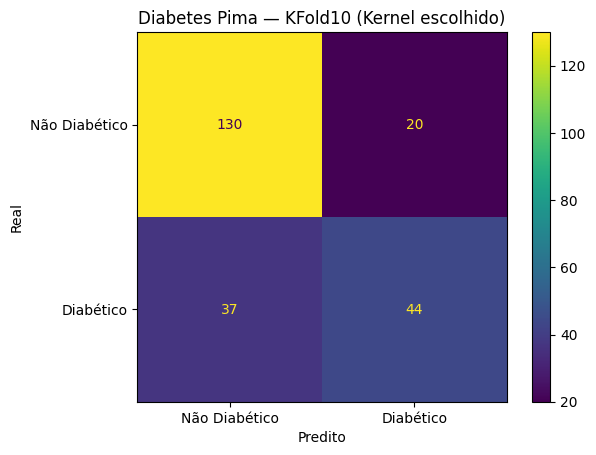

In [6]:
# GridSearch — Escolha do melhor Kernel
pipe_kernel_d_k10 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=RANDOM_STATE))
])

# Testando 4 tipos de kernel
param_grid_kernel = {"svm__kernel": ["linear", "rbf", "poly", "sigmoid"]}

grid_kernel_d_k10 = GridSearchCV(pipe_kernel_d_k10, param_grid_kernel, cv=cv_k10, n_jobs=-1)
grid_kernel_d_k10.fit(Xtr_d_k10, ytr_d_k10)

print("KFold10 — Melhor kernel:", grid_kernel_d_k10.best_params_["svm__kernel"])
print("KFold10 — Melhor score de validação:", grid_kernel_d_k10.best_score_)

pipe_kernel_d_k10 = grid_kernel_d_k10.best_estimator_
print("KFold10 — Acurácia teste:", accuracy_score(yte_d_k10, pipe_kernel_d_k10.predict(Xte_d_k10)))

plot_confusion_matrix(pipe_kernel_d_k10, Xte_d_k10, yte_d_k10, class_names_d, "Diabetes Pima — KFold10 (Kernel escolhido)")


1.5 Efeito de C e gamma

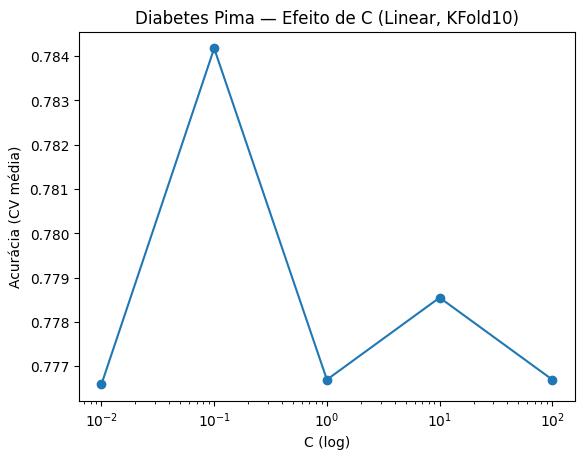

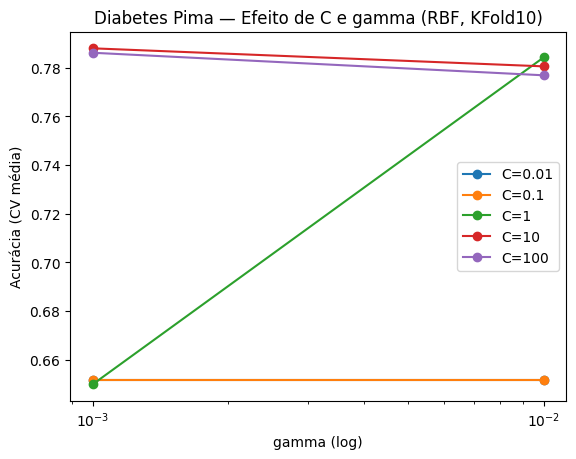

In [7]:
# Efeito de C (linear)
Cs = [0.01, 0.1, 1, 10, 100]
accs_linear_k10 = []

for C in Cs:
    pipe = Pipeline([("scaler", StandardScaler()),("svm", SVC(kernel="linear", C=C, random_state=RANDOM_STATE))])
    scores = cross_val_score(pipe, Xtr_d_k10, ytr_d_k10, cv=cv_k10, n_jobs=-1)
    accs_linear_k10.append(scores.mean())

plt.figure()
plt.plot(Cs, accs_linear_k10, marker="o")
plt.xscale("log")
plt.xlabel("C (log)")
plt.ylabel("Acurácia (CV média)")
plt.title("Diabetes Pima — Efeito de C (Linear, KFold10)")
plt.show()

# Efeito de C e gamma (RBF)
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.001]
results_k10 = {}

for C in Cs:
    for gamma in gammas:
        pipe = Pipeline([("scaler", StandardScaler()),("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=RANDOM_STATE))])
        scores = cross_val_score(pipe, Xtr_d_k10, ytr_d_k10, cv=cv_k10, n_jobs=-1)
        results_k10[(C, gamma)] = scores.mean()

plt.figure()
for C in Cs:
    ys = [results_k10[(C, g)] for g in gammas]
    plt.plot(gammas, ys, marker="o", label=f"C={C}")
plt.xscale("log")
plt.xlabel("gamma (log)")
plt.ylabel("Acurácia (CV média)")
plt.title("Diabetes Pima — Efeito de C e gamma (RBF, KFold10)")
plt.legend()
plt.show()

1.6 GridSearchCV completo (kernel + C + gamma)

Melhores hiperparâmetros (Diabetes Pima, KFold10): {'svm__C': 10, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
Melhor score de validação (KFold10): 0.7879105520614955
Desvio padrão ± 0.03985005794724862
Acurácia teste (KFold10, melhor combinação): 0.7359307359307359


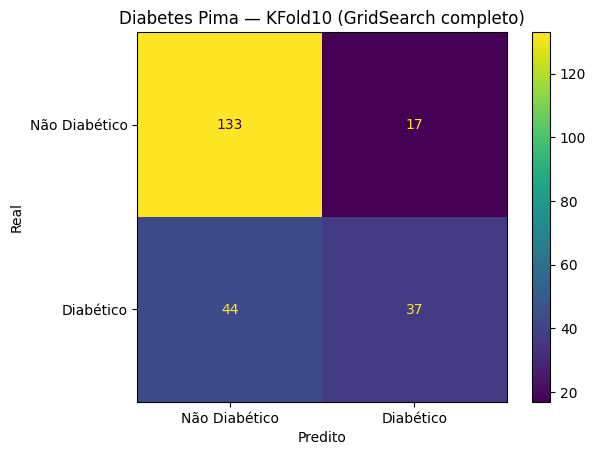

In [8]:
# GridSearch completo (Kernel, C, Gamma)
pipe_full_k10 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=RANDOM_STATE))
])

param_grid_full = {
    "svm__kernel": ["linear", "rbf", "poly", "sigmoid"],
    "svm__C": [0.01, 0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.01, 0.001]
}

grid_full_k10 = GridSearchCV(pipe_full_k10, param_grid_full, cv=cv_k10, n_jobs=-1)
grid_full_k10.fit(Xtr_d_k10, ytr_d_k10)

# Melhor modelo e desvio padrão do score
desvio_padrao = grid_full_k10.cv_results_['std_test_score'][grid_full_k10.best_index_]

print("Melhores hiperparâmetros (Diabetes Pima, KFold10):", grid_full_k10.best_params_)
print("Melhor score de validação (KFold10):", grid_full_k10.best_score_)
print("Desvio padrão ±", desvio_padrao)

best_model_k10 = grid_full_k10.best_estimator_
print("Acurácia teste (KFold10, melhor combinação):", accuracy_score(yte_d_k10, best_model_k10.predict(Xte_d_k10)))

plot_confusion_matrix(best_model_k10, Xte_d_k10, yte_d_k10, class_names_d, "Diabetes Pima — KFold10 (GridSearch completo)")


---

## **2) RepeatedKFold (5x2)**

2.1 Carregamento, divisão e visualização PCA (opcional)

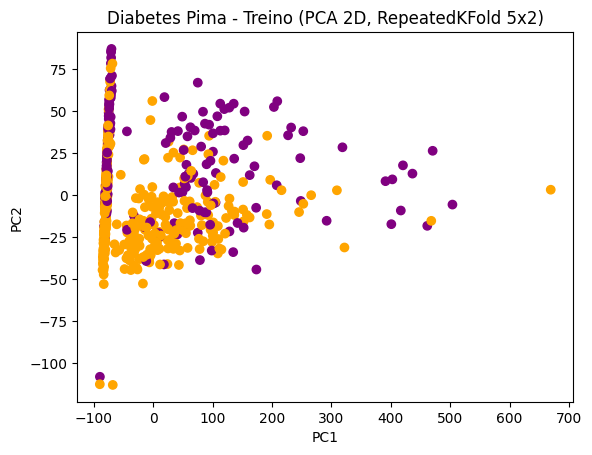

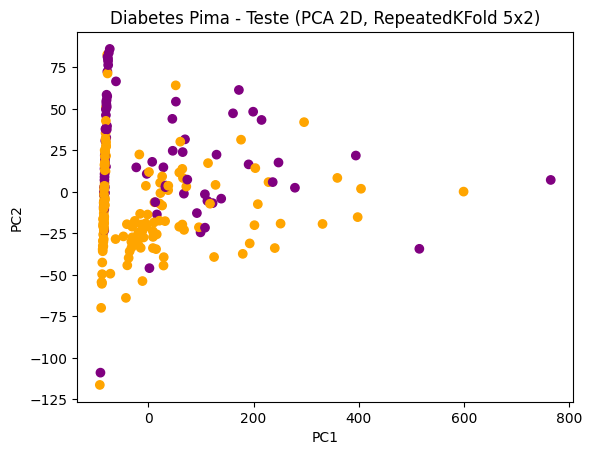

In [9]:
# Repetindo os experimentos com RepeatedKFold (5x2)
df = pd.read_csv("diabetes.csv")                    #
X_d = df.drop("Outcome", axis=1).values             #  Carregamento do dataset com foco em binario: diabético (1) e não diabético (0)
y_d = df["Outcome"].values                          #
class_names_d = ["Não Diabético", "Diabético"]

# Divisão treino/teste com RepeatedKFold (5x2)
Xtr_d_r5x2, Xte_d_r5x2, ytr_d_r5x2, yte_d_r5x2 = train_test_split(
    X_d, y_d, test_size=0.3, stratify=y_d, random_state=RANDOM_STATE
)

# Visualização PCA
scatter_pca_2d(Xtr_d_r5x2, ytr_d_r5x2, "Diabetes Pima - Treino (PCA 2D, RepeatedKFold 5x2)")
scatter_pca_2d(Xte_d_r5x2, yte_d_r5x2, "Diabetes Pima - Teste (PCA 2D, RepeatedKFold 5x2)")

2.2 SVM Linear (baseline)

Relatório — SVM Linear (Diabetes Pima, RepeatedKFold 5x2)

               precision    recall  f1-score   support

Não Diabético       0.76      0.85      0.80       150
    Diabético       0.65      0.49      0.56        81

     accuracy                           0.73       231
    macro avg       0.70      0.67      0.68       231
 weighted avg       0.72      0.73      0.72       231

Acurácia: 0.7272727272727273


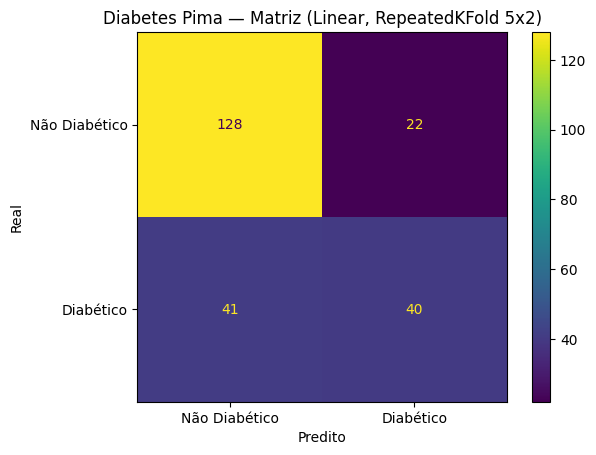

In [10]:
# Modelo SVM (Kernel Linear, RepeatedKFold)
pipe_linear_d_r5x2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear", random_state=RANDOM_STATE))
])

pipe_linear_d_r5x2.fit(Xtr_d_r5x2, ytr_d_r5x2)
ypred_d_r5x2 = pipe_linear_d_r5x2.predict(Xte_d_r5x2)


print("Relatório — SVM Linear (Diabetes Pima, RepeatedKFold 5x2)\n")
print(classification_report(yte_d_r5x2, ypred_d_r5x2, target_names=class_names_d))
print("Acurácia:", accuracy_score(yte_d_r5x2, ypred_d_r5x2))

plot_confusion_matrix(pipe_linear_d_r5x2, Xte_d_r5x2, yte_d_r5x2, class_names_d, "Diabetes Pima — Matriz (Linear, RepeatedKFold 5x2)")

2.3 Kernel não linear (RBF)

Relatório — SVM RBF (Diabetes Pima, RepeatedKFold 5x2)

               precision    recall  f1-score   support

Não Diabético       0.78      0.87      0.82       150
    Diabético       0.69      0.54      0.61        81

     accuracy                           0.75       231
    macro avg       0.73      0.70      0.71       231
 weighted avg       0.75      0.75      0.75       231

Acurácia: 0.7532467532467533


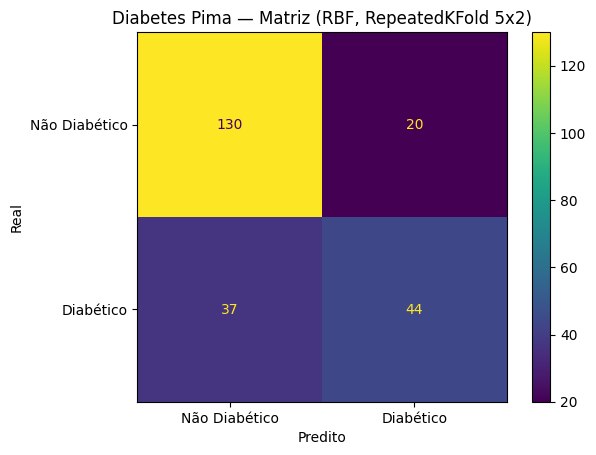

In [11]:
# Modelo SVM (Kernel RBF, RepeatedKFold)
pipe_rbf_d_r5x2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", random_state=RANDOM_STATE))
])

pipe_rbf_d_r5x2.fit(Xtr_d_r5x2, ytr_d_r5x2)
ypred_d_r5x2_rbf = pipe_rbf_d_r5x2.predict(Xte_d_r5x2)

print("Relatório — SVM RBF (Diabetes Pima, RepeatedKFold 5x2)\n")
print(classification_report(yte_d_r5x2, ypred_d_r5x2_rbf, target_names=class_names_d))
print("Acurácia:", accuracy_score(yte_d_r5x2, ypred_d_r5x2_rbf))

plot_confusion_matrix(pipe_rbf_d_r5x2, Xte_d_r5x2, yte_d_r5x2, class_names_d, "Diabetes Pima — Matriz (RBF, RepeatedKFold 5x2)")

2.4 GridSearchCV (apenas kernel)

RepeatedKFold 5x2 — Melhor kernel: linear
RepeatedKFold 5x2 — Melhor score de validação: 0.7821997230875736
RepeatedKFold 5x2 — Acurácia teste: 0.7272727272727273


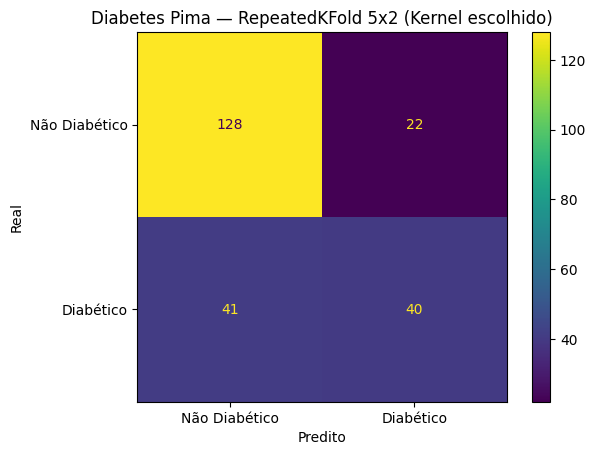

In [12]:
# GridSearch — Kernel (RepeatedKFold)
pipe_kernel_d_r5x2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=RANDOM_STATE))
])

param_grid_kernel = {"svm__kernel": ["linear", "rbf", "poly", "sigmoid"]}

grid_kernel_d_r5x2 = GridSearchCV(pipe_kernel_d_r5x2, param_grid_kernel, cv=cv_r5x2, n_jobs=-1)
grid_kernel_d_r5x2.fit(Xtr_d_r5x2, ytr_d_r5x2)

print("RepeatedKFold 5x2 — Melhor kernel:", grid_kernel_d_r5x2.best_params_["svm__kernel"])
print("RepeatedKFold 5x2 — Melhor score de validação:", grid_kernel_d_r5x2.best_score_)

pipe_kernel_d_r5x2 = grid_kernel_d_r5x2.best_estimator_
print("RepeatedKFold 5x2 — Acurácia teste:", accuracy_score(yte_d_r5x2, pipe_kernel_d_r5x2.predict(Xte_d_r5x2)))

plot_confusion_matrix(pipe_kernel_d_r5x2, Xte_d_r5x2, yte_d_r5x2, class_names_d, "Diabetes Pima — RepeatedKFold 5x2 (Kernel escolhido)")

2.5 Efeito de C e gamma

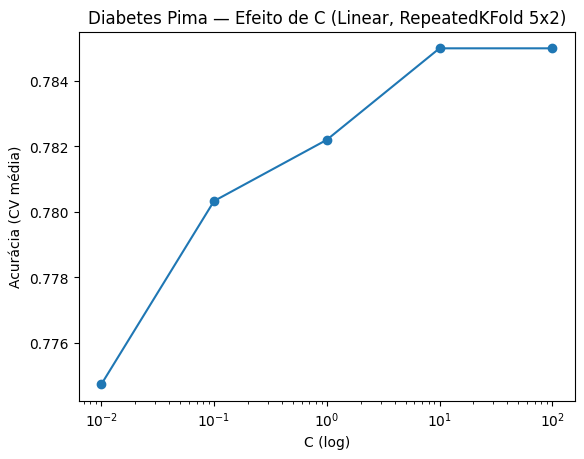

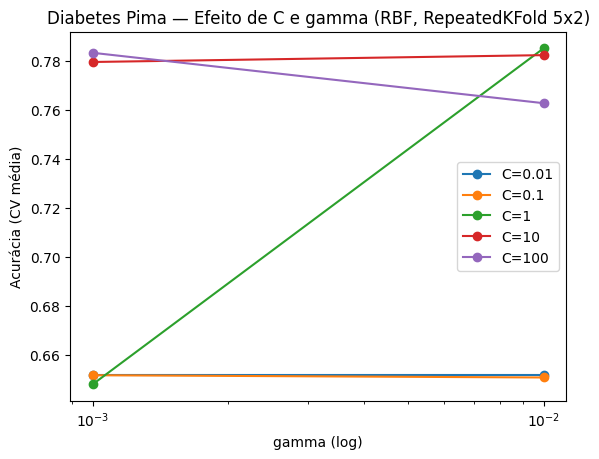

In [13]:
# Efeito de C (Linear, RepeatedKFold 5x2)
Cs = [0.01, 0.1, 1, 10, 100]
accs_linear_r5x2 = []

for C in Cs:
    pipe = Pipeline([("scaler", StandardScaler()),("svm", SVC(kernel="linear", C=C, random_state=RANDOM_STATE))])
    scores = cross_val_score(pipe, Xtr_d_r5x2, ytr_d_r5x2, cv=cv_r5x2, n_jobs=-1)
    accs_linear_r5x2.append(scores.mean())

plt.figure()
plt.plot(Cs, accs_linear_r5x2, marker="o")
plt.xscale("log")
plt.xlabel("C (log)")
plt.ylabel("Acurácia (CV média)")
plt.title("Diabetes Pima — Efeito de C (Linear, RepeatedKFold 5x2)")
plt.show()

# Efeito de C e gamma (RBF, RepeatedKFold)
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.001]
results_r5x2 = {}

for C in Cs:
    for gamma in gammas:
        pipe = Pipeline([("scaler", StandardScaler()),("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=RANDOM_STATE))])
        scores = cross_val_score(pipe, Xtr_d_r5x2, ytr_d_r5x2, cv=cv_r5x2, n_jobs=-1)
        results_r5x2[(C, gamma)] = scores.mean()

plt.figure()
for C in Cs:
    ys = [results_r5x2[(C, g)] for g in gammas]
    plt.plot(gammas, ys, marker="o", label=f"C={C}")
plt.xscale("log")
plt.xlabel("gamma (log)")
plt.ylabel("Acurácia (CV média)")
plt.title("Diabetes Pima — Efeito de C e gamma (RBF, RepeatedKFold 5x2)")
plt.legend()
plt.show()


2.6 GridSearchCV completo (kernel + C + gamma)

Melhores hiperparâmetros (Diabetes Pima, RepeatedKFold 5x2): {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Melhor score de validação (RepeatedKFold 5x2): 0.7849948078920042
Desvio padrão ± 0.06052067273271995
Acurácia teste (RepeatedKFold 5x2, melhor combinação): 0.7359307359307359


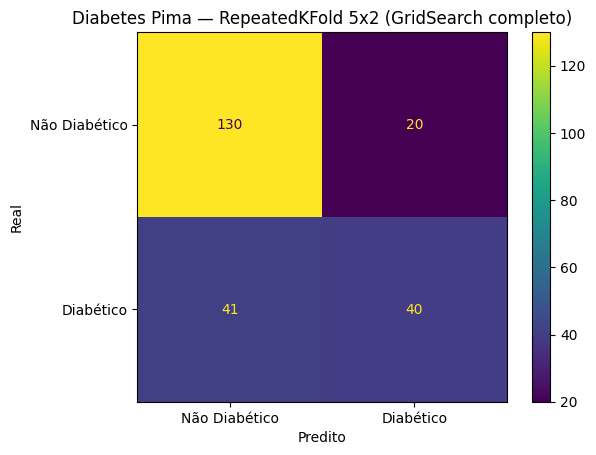

In [14]:
# GridSearch completo (Kernel, C, Gamma, RepeatedKFold)
pipe_full_r5x2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(random_state=RANDOM_STATE))
])

param_grid_full = {
    "svm__kernel": ["linear", "rbf", "poly", "sigmoid"],
    "svm__C": [0.01, 0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.01, 0.001]
}

grid_full_r5x2 = GridSearchCV(pipe_full_r5x2, param_grid_full, cv=cv_r5x2, n_jobs=-1)
grid_full_r5x2.fit(Xtr_d_r5x2, ytr_d_r5x2)
desvio_padrao = grid_full_r5x2.cv_results_['std_test_score'][grid_full_r5x2.best_index_]

print("Melhores hiperparâmetros (Diabetes Pima, RepeatedKFold 5x2):", grid_full_r5x2.best_params_)
print("Melhor score de validação (RepeatedKFold 5x2):", grid_full_r5x2.best_score_)
print("Desvio padrão ±", desvio_padrao)

best_model_r5x2 = grid_full_r5x2.best_estimator_
print("Acurácia teste (RepeatedKFold 5x2, melhor combinação):", accuracy_score(yte_d_r5x2, best_model_r5x2.predict(Xte_d_r5x2)))

plot_confusion_matrix(best_model_r5x2, Xte_d_r5x2, yte_d_r5x2, class_names_d, "Diabetes Pima — RepeatedKFold 5x2 (GridSearch completo)")


---

**Resumo rapido**

    KFold10: Kernel RBF, C=10, Gamma=0.001, Score de validação:0.787, Acurácia teste: 0.735, Desvio padrão ± 0.039

    RepeatedKFold 5x2: Kernel linear, C=10, Gamma=scale, Score de validação:0.784, Acurácia teste: 0.735, Desvio padrão ± 0.060

Os modelos chegaram na mesma acurácia de teste (0.735), sugerindo eficácia equivalente em termos de desempenho final.

Se a prioridade for estimativa mais confiável do desempenho (mais repetições, menor risco de viés na validação) e o custo computacional não for problema, vai de RepeatedKFold 5x2 com kernel linear sendo ele mais robusto, com o porém do desvio padrão ultrapassar 5% tornando um pouco mais instável.

Se a prioridade for simplicidade e rapidez de validação, o KFold10 com kernel RBF é suficiente, já que o resultado final foi o mesmo e com o acrescimo de um desvio padrão mais confiável.